# Pulsar Data Classification

## Introduction

Pulsars belong to a family of objects called neutron stars. These are basically “dead” stars – what results when a star more massive than the sun runs out of fuel and collapses on itself. Neuron stars are typically 20-24 km. but can contain twice the mass of the sun **[1]**. A characteristic property of pulsars are the periodic bursts of emissions, or ‘flickers’, produced by their beams of light. In reality, however, pulsars don’t flicker, they spin. What we perceive to be a flicker is simply the pulsar’s beam of light constantly swinging in and out of view, but the effect is similar to the flicker that a sailor perceives when approaching a lighthouse **[2]**.
 
To help properly classify a data sample as either a pulsar or noise (i.e. man-made frequencies), scientists use two sets of variables. The first set is the integrated profile, which is the result of stacking the individual bursts of emission or ‘flickers’ from a pulsar. Pulses arrive at different times across different radio frequencies. To account for the effect of the delay, scientists fit the shape of the delay in what is the DM-SNR (“dispersion-measure-signal-to-noise-ratio”) curve. This curve constitutes the second set of variables.
 
To build our classification model we use the HTRU2 data set, which “describes a sample of pulsar candidates collected during the High Time Resolution Universe Survey” **[3]**. The data set contains eight continuous variables and one binary variable, with each continuous variable representing a numerical characteristic of the pulsar candidates.  Each continuous variable appears once for the integrated pulse profile, and once for the DM-SNR curve. The binary variable (called Class) appears only once, and takes on the values 0 and 1, with Class = 0 meaning that the pulsar candidate is the result of noise, and Class = 1 meaning that the pulsar candidate is a real pulsar **[4]**.
 
The variables are:
 
Mean
- Standard deviation
- Kurtosis – (how heavily the tails of a distribution differ from the tails of a normal distribution)
- Skewness – (the asymmetry in a normal distribution)
- Class
 
The data set contains 17,898 observations, out of which 16,259 are examples caused by noise (Class = 0), and 1,639 are real examples (Class = 1).
 
**What we want to know is, given the mean, standard deviation, kurtosis, and skewness of both the integrated profile and the DM-SNR curve of a sample of radio-wave radiation, is the source of the radiation a real pulsar or noise?**

## Methods and Results
We applied the K-nearest neighbours algorithm to develop our binary classification model, utilizing all 8 variables available in our data set.

In [2]:
#load all necessary libraries for data analysis
library(tidyverse)
library(repr)
library(rvest)
library(stringr)
library(caret)
library(ggplot2)
library(reshape)

#reading data from the web
temp <- tempfile()
download.file("https://archive.ics.uci.edu/ml/machine-learning-databases/00372/HTRU2.zip", temp)
pulsar_file <- unz(temp, "HTRU_2.csv")
pulsar <- read_csv(pulsar_file, col_names = FALSE)
colnames(pulsar) = c("mean_integrated", "sd_integrated", "kurtosis_integrated", "skew_integrated", "mean_DMSNR", "sd_DMSNR", "kurtosis_DMSNR", "skew_DMSNR", "target_class")
pulsar = mutate(pulsar, target_class = as.factor(target_class))
head(pulsar)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.2.0     ✔ purrr   0.3.2
✔ tibble  2.1.3     ✔ dplyr   0.8.3
✔ tidyr   0.8.3     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: xml2

Attaching package: ‘rvest’

The following object is masked from ‘package:purrr’:

    pluck

The following object is masked from ‘package:readr’:

    guess_encoding

Loading required package: lattice

Attaching package: ‘caret’

The following object is masked from ‘package:purrr’:

    lift


Attaching package: ‘reshape’

The following object is masked from ‘package:dplyr’:

    rename

The following objects are masked from ‘package:tidyr’:

    expand, smiths

Parsed with column specification:
cols(
  X1 = col_double(),
  X2 = col_double(),
  X3 = col_double(),
  X4 = col_doub

mean_integrated,sd_integrated,kurtosis_integrated,skew_integrated,mean_DMSNR,sd_DMSNR,kurtosis_DMSNR,skew_DMSNR,target_class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
140.56250,55.68378,-0.23457141,-0.6996484,3.199833,19.11043,7.975532,74.24222,0
102.50781,58.88243,0.46531815,-0.5150879,1.677258,14.86015,10.576487,127.39358,0
103.01562,39.34165,0.32332837,1.0511644,3.121237,21.74467,7.735822,63.17191,0
136.75000,57.17845,-0.06841464,-0.6362384,3.642977,20.95928,6.896499,53.59366,0
88.72656,40.67223,0.60086608,1.1234917,1.178930,11.46872,14.269573,252.56731,0
93.57031,46.69811,0.53190485,0.4167211,1.636288,14.54507,10.621748,131.39400,0


**_Table 1 - Pulsar data_**

Below is a quick exploration of how the predictors relate to one another by looking at their correlations.

In [43]:
options(repr.plot.width = 6, repr.plot.height = 6)

pulsar_num = mutate(pulsar, target_class = as.numeric(target_class))
cormat <- round(cor(pulsar_num),2)
melted_cormat <- melt(cormat)
head(melted_cormat)

X1,X2,value
<fct>,<fct>,<dbl>
mean_integrated,mean_integrated,1.00
sd_integrated,mean_integrated,0.55
kurtosis_integrated,mean_integrated,-0.87
skew_integrated,mean_integrated,-0.74
mean_DMSNR,mean_integrated,-0.30
sd_DMSNR,mean_integrated,-0.31


**_Table 2 - Predictors dorrelation raw data_**

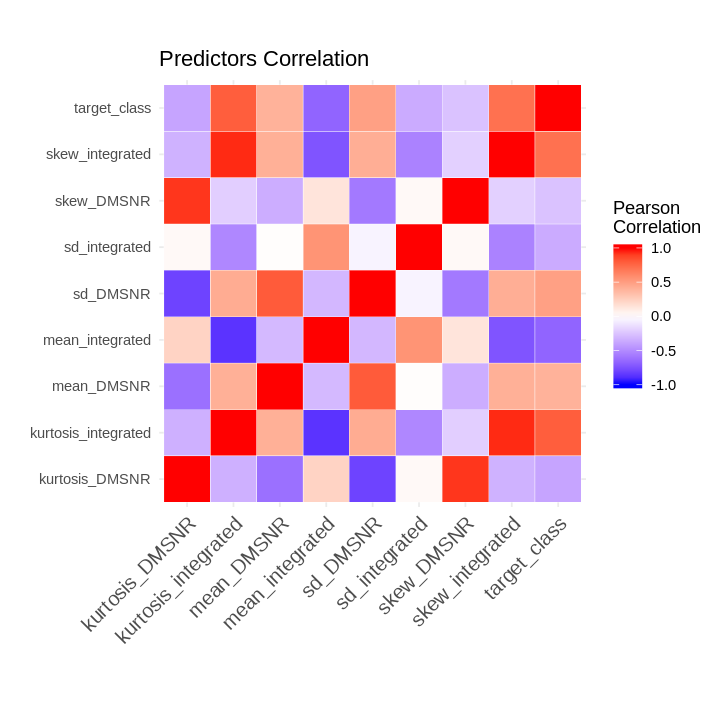

In [44]:
ggplot(data = melted_cormat, aes(X2, X1, fill = value))+
ggtitle("Predictors Correlation") +
labs(x = " ", y = " ") +
 geom_tile(color = "white")+
 scale_fill_gradient2(low = "blue", high = "red", mid = "white", 
   midpoint = 0, limit = c(-1,1), space = "Lab", 
 name="Pearson\nCorrelation") +
 theme_minimal()+ 
 theme(axis.text.x = element_text(angle = 45, vjust = 1, 
    size = 12, hjust = 1))+
 coord_fixed()

**_Figure 1 - Predictors correlation_**

### Balancing classes

By using `group_by` and `summarize`, we discovered a class imbalance in our data—observations with negative class labels were significantly more common than those with positive ones.  There are 16259 negative labels and only 1639 positive label results. This will bring the problem on the accuracy especially when using a high k value. So here we will replicate rare observations multiple times in our data set to give them more voting power in the K-nearest neighbour algorithm. In order to do this, we will use the `upSample` function from the `caret` library.

In [8]:
# view number of instances of each target_class
pulsar_summarized <- pulsar %>%
    group_by(target_class) %>%
    summarize(n = n())
head(pulsar_summarized)

target_class,n
<fct>,<int>
0,16259
1,1639


**_Table 3 - Number of observations by class before upsample_**

In [9]:
set.seed(12345)

# balance the observations between classes, here target_class column is renamed as Class
pulsar_balanced <- upSample(x = select(pulsar, -target_class),
            y = select(pulsar, target_class) %>% unlist())

# view number of instances of each Class
pulsar_summarized <- pulsar_balanced %>%
    group_by(Class) %>%
    summarize(n = n())
head(pulsar_summarized)

Class,n
<fct>,<int>
0,16259
1,16259


**_Table 4 - Number of observations by class after upsample_**

### Splitting and Standardizing the Dataset

We then split our balanced data into training and testing sets using `createDataPartition`, with a train-test split of 75%-25%. 

In [11]:
training_rows <- pulsar_balanced %>%
    select(Class) %>%
    pull() %>%
    createDataPartition(p = 0.75, list = FALSE)

training_set <- slice(pulsar, training_rows)
testing_set <- slice(pulsar, -training_rows)

head(training_set)

mean_integrated,sd_integrated,kurtosis_integrated,skew_integrated,mean_DMSNR,sd_DMSNR,kurtosis_DMSNR,skew_DMSNR,target_class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
102.50781,58.88243,0.46531815,-0.5150879,1.677258,14.86015,10.576487,127.39358,0
103.01562,39.34165,0.32332837,1.0511644,3.121237,21.74467,7.735822,63.17191,0
136.75000,57.17845,-0.06841464,-0.6362384,3.642977,20.95928,6.896499,53.59366,0
88.72656,40.67223,0.60086608,1.1234917,1.178930,11.46872,14.269573,252.56731,0
93.57031,46.69811,0.53190485,0.4167211,1.636288,14.54507,10.621748,131.39400,0
107.25000,52.62708,0.45268802,0.1703474,2.331940,14.48685,9.001004,107.97251,0


**_Table 5 - Training set_**

In [12]:
head(testing_set)

mean_integrated,sd_integrated,kurtosis_integrated,skew_integrated,mean_DMSNR,sd_DMSNR,kurtosis_DMSNR,skew_DMSNR,target_class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
140.5625,55.68378,-0.23457141,-0.6996484,3.1998328,19.110426,7.975532,74.24222,0
119.4844,48.76506,0.03146022,-0.1121676,0.9991639,9.279612,19.206230,479.75657,0
130.3828,39.84406,-0.15832276,0.3895404,1.2207358,14.378941,13.539456,198.23646,0
112.7188,50.30127,0.27939095,-0.1290107,8.2817726,37.810012,4.691827,21.27621,0
123.2109,51.07801,0.17937682,-0.1772852,2.1070234,16.921773,10.080333,112.55859,0
110.1094,41.31817,0.09486040,0.6831126,1.0100334,13.026275,14.666511,231.20414,0


**_Table 6 - Testing set_**

To ensure that the scale and center of each variable does not affect the algorithm (that is, since k-nn classification consider the distance between data points, we do not want the predictors to be weighted differently in such calculation), we used the training set to create a scaling transformer and standardized both the training and testing sets.

In [13]:
scale_transformer <- preProcess(training_set, method = c("center", "scale")) 
training_set <- predict(scale_transformer, training_set)
testing_set <- predict(scale_transformer, testing_set)

head(training_set)

mean_integrated,sd_integrated,kurtosis_integrated,skew_integrated,mean_DMSNR,sd_DMSNR,kurtosis_DMSNR,skew_DMSNR,target_class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
-0.3315704,1.79648779,-0.01457721,-0.3710077,-0.3714409,-0.5910664,0.5038534,0.21000533,0
-0.3117880,-1.05148146,-0.14765118,-0.1177992,-0.3227400,-0.2387426,-0.1235637,-0.38763593,0
1.0023681,1.54814120,-0.51479586,-0.3905935,-0.3051434,-0.2789358,-0.3089449,-0.47677028,0
-0.8684327,-0.85755679,0.11245939,-0.1061064,-0.3882479,-0.7646267,1.3195447,1.37486110,0
-0.6797396,0.02068571,0.04782837,-0.2203666,-0.3728227,-0.6071905,0.5138503,0.24723293,0
-0.1468337,0.88480214,-0.02641427,-0.2601967,-0.3493605,-0.6101701,0.1558769,0.02927451,0


**_Table 7 - Scaled training set_**

In [14]:
head(testing_set)

mean_integrated,sd_integrated,kurtosis_integrated,skew_integrated,mean_DMSNR,sd_DMSNR,kurtosis_DMSNR,skew_DMSNR,target_class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1.15088787,1.3303012,-0.6705193,-0.4008447,-0.3200892,-0.3735531,-0.07061907,-0.28461654,0
0.32976853,0.3219325,-0.4211923,-0.3058695,-0.3943108,-0.8766568,2.40990329,3.48906454,0
0.75432801,-0.9782583,-0.5990585,-0.2247608,-0.3868379,-0.6156926,1.15828389,0.86926296,0
0.06620687,0.5458274,-0.1888297,-0.3085924,-0.1486914,0.5834206,-0.79589039,-0.77751366,0
0.47494048,0.6590336,-0.2825637,-0.3163967,-0.3569462,-0.4855601,0.39426807,0.07195222,0
-0.03544393,-0.7634137,-0.3617732,-0.1773004,-0.3939442,-0.6849169,1.40721628,1.17605731,0


**_Table 8 - Scaled testing set_**

We separated our training and testing sets into their predictor variables (`X`) and class labels (`Y`): `X_train`, `Y_train`, `X_test` and `Y_test`  respectively. Here the X sets are left as data frame and the Y sets will t be converted into vectors.

In [16]:
X_train <- training_set %>%
    select(-target_class) %>%
    data.frame()

Y_train <- training_set %>%
    select(target_class) %>%
    pull()

X_test <- testing_set %>%
    select(-target_class) %>%
    data.frame()

Y_test <- testing_set %>%
    select(target_class) %>%
    pull()

### Model training and evaluating

To get a k-nn classification model with the highest accuracy, we attempt to choose an optimal k value (the number of neighbor considered). To do so, we conducted 10-fold cross-validation with our training set. This was done using `trainControl`, which splits our data into 10 chunks with each iteration, with 1 chunk as the validation set and the remaining 9 chunks as the collective training set. We evaluated the accuracy of odd *K* values from 1 to 21 (to avoid ties), ending up with an optimal value of *K* = 7 and an accuracy of 0.978, as output below.

In [17]:
# choose k from 1 to 20
ks = data.frame(k = seq(1, 21, by = 2))

train_control <- trainControl(method = "cv", number = 10)

set.seed(12345)

choose_k <- train(x = X_train, y = Y_train, method = "knn", tuneGrid = ks, trControl = train_control)
choose_k

k-Nearest Neighbors 

13422 samples
    8 predictor
    2 classes: '0', '1' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 12079, 12080, 12080, 12081, 12079, 12079, ... 
Resampling results across tuning parameters:

  k   Accuracy   Kappa    
   1  0.9704973  0.8236986
   3  0.9773516  0.8595972
   5  0.9775746  0.8598071
   7  0.9782455  0.8636576
   9  0.9777239  0.8599183
  11  0.9775750  0.8584981
  13  0.9772769  0.8567455
  15  0.9773513  0.8566143
  17  0.9773514  0.8564961
  19  0.9774260  0.8569194
  21  0.9772769  0.8561246

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was k = 7.

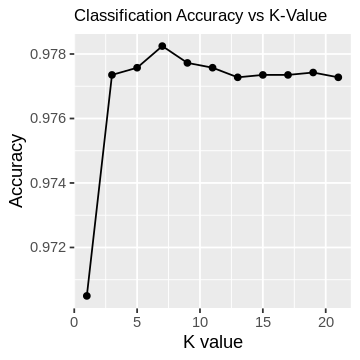

In [39]:
# visualization of how accuracy changes with k values
k_Accuracy <- choose_k$results %>%
                    select(k, Accuracy)
options(repr.plot.height = 3, repr.plot.width = 3)
choosing_k <- ggplot(k_Accuracy, aes(x = k, y = Accuracy)) +
                geom_point() +
                geom_line() +
                xlab("K value") +
                ylab("Accuracy") +
                ggtitle("Classification Accuracy vs K-Value") +
                theme(plot.title = element_text(size = 10))
choosing_k

**_Figure 2 - Classification accuracy vs K-value from 10-fold cross validation on training set_**

Using K = 7, we retrained our classifier on our training data. We then used a `confusionMatrix` to assess the quality of our model and visualize its analysis on both the training and testing sets. From this visualization, we were able to determine that our model has an accuracy of 0.981 with our training data, and an accuracy of 0.980 with our testing data.

In [19]:
set.seed(12345)
best_k <- choose_k$results %>%
    filter(Accuracy == max(Accuracy)) %>%
    select(k) %>%
    pull()

final_k = data.frame(k = best_k)
model  <- train(X_train, y = Y_train, method = "knn", tuneGrid = final_k)

# using the model on training set
print("training set prediction results")
train_pred <- predict(model, X_train)
train_results <- confusionMatrix(train_pred, Y_train)

train_results

#using the model on the testing set
print("testing set prediction results")
test_pred <- predict(model, X_test)
test_results <- confusionMatrix(test_pred, Y_test)

test_results

[1] "training set prediction results"


Confusion Matrix and Statistics

          Reference
Prediction     0     1
         0 12118   196
         1    58  1050
                                          
               Accuracy : 0.9811          
                 95% CI : (0.9786, 0.9833)
    No Information Rate : 0.9072          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.8818          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.9952          
            Specificity : 0.8427          
         Pos Pred Value : 0.9841          
         Neg Pred Value : 0.9477          
             Prevalence : 0.9072          
         Detection Rate : 0.9028          
   Detection Prevalence : 0.9174          
      Balanced Accuracy : 0.9190          
                                          
       'Positive' Class : 0               
                  

[1] "testing set prediction results"


Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 4062   69
         1   21  324
                                          
               Accuracy : 0.9799          
                 95% CI : (0.9753, 0.9838)
    No Information Rate : 0.9122          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.8671          
                                          
 Mcnemar's Test P-Value : 7.262e-07       
                                          
            Sensitivity : 0.9949          
            Specificity : 0.8244          
         Pos Pred Value : 0.9833          
         Neg Pred Value : 0.9391          
             Prevalence : 0.9122          
         Detection Rate : 0.9075          
   Detection Prevalence : 0.9229          
      Balanced Accuracy : 0.9096          
                                          
       'Positive' Class : 0               
                        

### Visualization

Finally, we visualize how accurate the predictions are across the reference classes. The plot shows that the model is very accurate on predicting false pulsar signals but tend to give proportionally more false negative predictions when it comes to a true signal.

In [46]:
#data.frame(test_results$table)
test_result_table <- data.frame(test_results$table) %>%
    group_by(Reference) %>%
    mutate(proportion = Freq / sum(Freq), status = (as.character(Reference) == as.character(Prediction)))
test_result_table

Prediction,Reference,Freq,proportion,status
<fct>,<fct>,<int>,<dbl>,<lgl>
0,0,4062,0.994856723,TRUE
1,0,21,0.005143277,FALSE
0,1,69,0.175572519,FALSE
1,1,324,0.824427481,TRUE


**_Table 9 - Prediction vs Reference by class label raw data_**

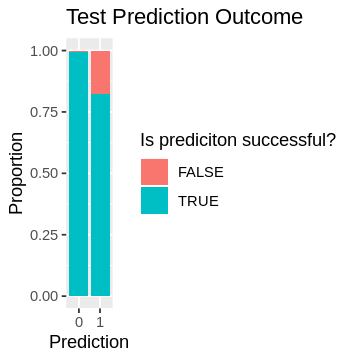

In [52]:
options(repr.plot.width = 3, repr.plot.height = 3)

test_result_plot <- test_result_table %>%
    ggplot(aes(x = Reference, y = proportion, fill = status))+
    geom_bar(stat = 'identity') +
    labs (x = "Prediction", y = "Proportion", fill = "Is prediciton successful?") +
    ggtitle("Test Prediction Outcome")
test_result_plot

**_Figure 3 - Prediction vs Reference by class label_**

## Discussion

_**Summarize what you found**_

It was found that the K-nearest neighbours classifier developed in the Methods and Results section had an accuracy of 97.99%. This means that roughly every 49/50 predictions the classifier makes for if the source of a sample of radio-wave radiation is a pulsar or not will be correct, or, roughly 1/50 predictions will be incorrect.

These accuracy figures were extracted from testing the classifier on a separated test set, sourced from the upsampled original dataset. The end result was the following confusion matrix, from which the classification accuracy was calculated:

|   |   0  |  1  |
|---|:----:|:---:|
| **0** | 4062 |  69 |
| **1** |  21  | 324 |

<p style="text-align: center;"><i><strong>Table 10 - Confusion matrix</strong></i></p>

**_Discuss whether this is what you expected to find?_**

A classifier with a decent accuracy is what we expected to develop, although, given the number of potential stars in the dataset, compared with the amount in the universe (billions), it was clear to us that any classifier we made would not have anywhere near perfect accuracy. To achieve that, we’d need much more data. 

The achieved classification accuracy of ~98% is certainly not bad. However, simply looking at the percentage is not a great way to gauge if the classifier is an acceptable one; what the classifier is classifying must be considered. For example, a spam email filter having 98% accuracy is great; the 2% that do get through; well, they’re just emails, not too high stakes. But 98% accuracy for a classifier that recognizes human pedestrians from other objects in a self-driving system would be absolutely unacceptable. If that system was put into wide use, that 2% would amount to thousands of pedestrians on the road going unrecognized by cars driving themselves. Not a good state of affairs. 

Thus, for recognizing pulsar stars from noise, our classifier certainly made some false predictions; a total of 90 out of 4,476 predictions were incorrect. When you think about it in this sense, looking at the raw numbers, it becomes clear that our classifier is not suitable for use, by, say, professional astronomers. 90 starts going being wrongly classified is no small figure. Yes, of course, there are billions of stars in the universe, so 90 is perhaps insignificant. However, if we are making the effort of classifying them in the first place, our standard of classification should not be so low that hundreds go wrongly classified, as is the case with this classifier.

**_Discuss what impact could such findings have?_**

However, our findings allow us to know one thing, and that is there are clear differences between the noise a pulsar star emits and other man made noise. Using these differences and a little bit of statistical analysis, we are able to almost always predict whether or not the radiation noise is coming from a star. For astronomers, this is good news. This means that not only can we accurately study pulsar stars instead of man made noise, we can also analyze the differences between the noises and speculate on why they occur. What our findings allow us to know is that there is definitely a difference, the next question would be finding out why that is.

**_Discuss what future questions could this lead to?_**

Being able to study pulsar stars allows us to understand the life cycle of stars, locate nearby star clusters, and measure other cosmic differences. It’s important for astronomers to be able to differentiate pulsar stars from other cosmic noises, and our findings are the beginning of it. However, our subset of data is still quite limited. Perhaps there are larger data frames that include soundwaves that are neither man-made or from pulsar stars. Perhaps there are different types of pulsar stars that emit different radioactive wavelengths. Perhaps all of the errors of our model come from pulsar stars a particular distance away. There are so many more questions left to be answered, and we hope that our findings, however small, contributes to the much larger and expansive picture of pulsar stars. 

## References

**[1]** Cofield, C. (2016, April 22). What are pulsars? Space.com
https://www.space.com/32661-pulsars.html
 
**[2]** CSC2019 – Introduction to Machine Learning.
https://as595.github.io/classification/?fbclid=IwAR2CAnxooYKNA-lbvnwBSvINUdYPq5LrxEsKZrFU2YTcImHPvJqBwyhSv1Q
 
**[3]** R. J. Lyon, B. W. Stappers, S. Cooper, J. M. Brooke, J. D. Knowles, Fifty Years of Pulsar Candidate Selection: From simple filters to a new principled real-time classification approach, Monthly Notices of the Royal Astronomical Society 459 (1), 1104-1123, DOI: 10.1093/mnras/stw656
 
**[4]** R. J. Lyon, HTRU2, DOI: 10.6084/m9.figshare.3080389.v1.